In [172]:
import pandas as pd 
import os
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from subprocess import check_output
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMAResults
from pandas import datetime
from sklearn.metrics import mean_squared_error
df = pd.read_csv("../Resources/btcjoin.csv", index_col='date', parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open','value','address','mined'])
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
print(df.tail())
#https://medium.com/@cortexmoldova/arima-time-series-forecasting-model-with-python-5b0cfdbb08fa


              price
date               
2022-10-21  19162.6
2022-10-22  19204.8
2022-10-23  19571.2
2022-10-24  19331.5
2022-10-25  20073.1


C:\Users\16474\AppData\Local\Temp\ipykernel_10528\66652017.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


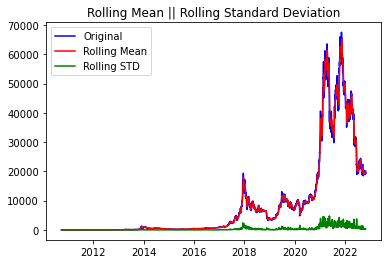

In [173]:

# Visualise if the data is stationary or not
rolling_mean = df.rolling(window = 8).mean()
rolling_std = df.rolling(window = 8).std()

# ploting the data
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'green', label = 'Rolling STD')
plt.legend(loc = 'best')
plt.title('Rolling Mean || Rolling Standard Deviation')
plt.show()

In [174]:
# getting the result of:
# >> ADF Statistic
# >> P-Values
# >> Critical Values
result = adfuller(df['price'])
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.7692030079691388
P-Values: 0.3958551417121587
Critical Values: 
	1%: -3.4318527927183196
	5%: -2.86220405019551
	10%: -2.5671234784459993


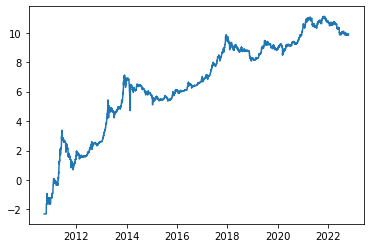

In [175]:
# Taking the log of the data
df_log = np.log(df)
plt.plot(df_log)

In [176]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='green', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['price'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

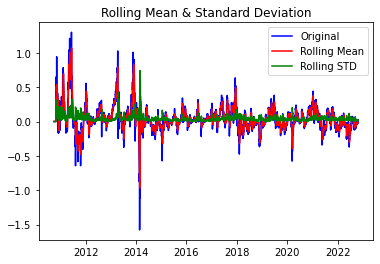

ADF Statistic: -9.378623941273611
p value: 7.055471370589519e-16
Critical Values:
	1%: -3.431844208138311
	5%: -2.8622002578158217
	10%: -2.5671214595731113


In [177]:
# Exponential decay method
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

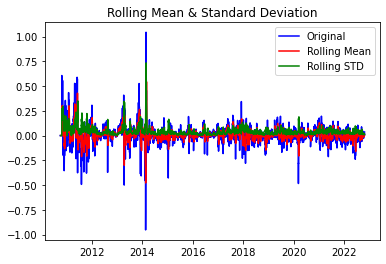

ADF Statistic: -17.69130501681446
p value: 3.571174871230646e-30
Critical Values:
	1%: -3.4318469445135458
	5%: -2.8622014666558626
	10%: -2.5671221030987654


In [178]:
# Subtracting the rolling mean
rolling_mean = df_log.rolling(window=8).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

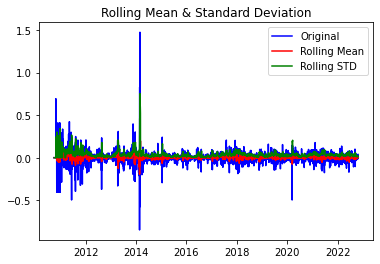

ADF Statistic: -25.023770405876363
p value: 0.0
Critical Values:
	1%: -3.431844208138311
	5%: -2.8622002578158217
	10%: -2.5671214595731113


In [179]:
# The time sifting
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

c:\Users\16474\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\16474\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\16474\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


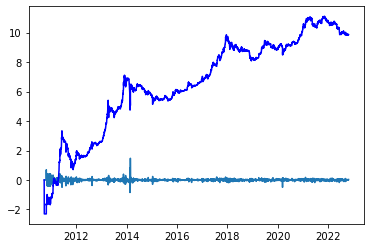

In [184]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
# ARIMA model


# decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='blue')